## Overlay radio contour on optical images to see if YMCs are embedded

Import packages

In [85]:
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import numpy as np
from reproject import reproject_interp
from reproject import reproject_exact
from regions import read_ds9
import copy
from photutils import SkyCircularAperture
import time
import pandas as pd

In [86]:
def fits_import(fitsimage, item=0):
    hdr = fits.open(fitsimage)[item].header
    wcs = WCS(hdr).celestial
    data=fits.open(fitsimage)[item].data
    data=np.squeeze(data)
    data_masked=np.ma.masked_invalid(data)

    return wcs, data

def cut_2d(data,position,size,wcs):
    cut=Cutout2D(data=data,position=position,size=size,wcs=wcs)
    data_cut=cut.data
    wcs_cut=cut.wcs

    return wcs_cut, data_cut

def import_coords(regionfile, ra_add = 0*u.arcsec, dec_add = 0*u.arcsec):
    regions = read_ds9(regionfile)
    coords = []
    for region in regions:
        coord = region.center
        coord = SkyCoord(ra=coord.ra+ra_add, dec=coord.dec+dec_add, frame='icrs')
        coords.append(coord)

    return coords

def HST_flux(values, photflam, EE=1):
    fluxes = values * photflam / EE
    
    return fluxes

Directories

In [94]:
Dir = '/home/heh15/research/Antennae/'
picDir = Dir+'pictures/'
regionDir = Dir+'regions/'
HST_Dir = Dir+'HST/'
MUSE_Dir = Dir+'MUSE/'
imageDir = Dir+'images/'

# data
cont_Band3_GMC = Dir + '2018/cont_100GHz/image/'\
                       'ngc4038_band3_cont_12m_7m.fits'
cont_Band3_SC = Dir + '2016/Band3/ngc40389overlap_band3_uvrange_robust_2_smooth.fits'
cont_Band3_SC_p5 = Dir + '2016/Band3/ngc40389overlap_band3_uvrange_robust_p5_smooth_pbcor.fits'
cont_Band3_SC_p5_009 = Dir + '2016/Band3/ngc40389overlap_band3_uvrange_robust_p5_smooth_090_pbcor.fits'
cont_Band6_GMC = Dir + '2018/cont_200GHz/image/'\
                       'ngc4038_band6_cont_12m_7m.fits'
cont_Band7_SC = Dir + '2016/Band7/ngc40389overlap_band7_range_robust_2_smooth.fits'
cont_Band7_SC_p5 = Dir + '2016/Band3/ngc40389overlap_band7_range_robust_p5_smooth_pbcor.fits'

#### Load the data

In [96]:
OpticalTypes = ['I','Halpha','NIR','Pbeta']
OpticalParams = dict.fromkeys(OpticalTypes)
for key in OpticalParams.keys():
    OpticalParams[key] = {}

OpticalParams['I']['filename'] = HST_Dir + 'ib5u20090_drz.fits'
OpticalParams['NIR']['filename'] = HST_Dir + 'ib5u20060_drz.fits'
OpticalParams['Pbeta']['filename'] = HST_Dir + 'ib5u91050_drz.fits'
OpticalParams['Halpha']['filename'] = MUSE_Dir + 'ADP.2016-06-17T16:27:49.394.fits'
OpticalParams['Pbeta']['filename'] = HST_Dir + 'Antennae_Pbeta_contsub.fits'

datatype = 'Pbeta'
wcs, data_masked = fits_import(OpticalParams[datatype]['filename'], item=1)
data = data_masked
np.nanmean(data)

# hdr0 = fits.open(OpticalParams[datatype]['filename'])[0].header
# photflam= hdr0['PHOTFLAM']


0.012548834702426724

Load the star cluster positions

In [97]:
regionfile = regionDir + 'source_coords_band3.reg'
coords = import_coords(regionfile)
coords_txt = copy.deepcopy(coords)
for i, coord in enumerate(coords):
    coords_txt[i] = SkyCoord(ra=coord.ra-0.5*u.arcsec, dec=coord.dec+0.5*u.arcsec, frame='icrs')

coords_txt[2] = SkyCoord(ra=coords[2].ra+5*u.arcsec, dec=coords[2].dec-1*u.arcsec, frame='icrs')
coords_txt[3] = SkyCoord(ra=coords[3].ra+5*u.arcsec, dec=coords[3].dec-3*u.arcsec, frame='icrs')
coords_txt[4] = SkyCoord(ra=coords[4].ra+4*u.arcsec, dec=coords[4].dec-1*u.arcsec, frame='icrs')
print(coords_txt)

[<SkyCoord (ICRS): (ra, dec) in deg
    (180.47886511, -18.88482311)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.47730411, -18.88406611)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.47454789, -18.88617378)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.47437289, -18.88700333)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.48177011, -18.88062578)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.48022011, -18.87997011)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.48094811, -18.87920711)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.47962511, -18.87787711)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.47799011, -18.87523411)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.46707511, -18.87229411)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.47096211, -18.86816211)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.47075811, -18.86710411)>, <SkyCoord (ICRS): (ra, dec) in deg
    (180.47726711, -18.86556811)>]


#### Rotate the image and save it to fits file

In [98]:
# create a new wcs that directed towards north
wcs_north = WCS(naxis=2)
wcs_north.wcs.crval = wcs.wcs.crval
wcs_north.wcs.crpix = wcs.wcs.crpix
cd = wcs.wcs.cd
wcs_north.wcs.cd = np.sqrt(cd[0,0]**2+cd[1,0]**2)*np.array([[-1,0],[0,1]])
wcs_north.wcs.ctype = ['RA---SIN', 'DEC--SIN']
start = time.time()
data_north, footprint = reproject_exact((data, wcs), wcs_north, shape_out=np.shape(data),parallel=True)
stop = time.time()
duration = stop-start
print(str(duration)+' s')

# Save the rotated image
outputfits = imageDir + 'Antennae_HST_'+str(datatype)+'_north.fits'
header = wcs_north.to_header()
hdu = fits.PrimaryHDU(data_north, header)
hdu.writeto(outputfits, overwrite=True)

11.354684591293335 s


#### Show the Paschen beta image

Read the rotated Paschen beta image

In [99]:
datatype = 'Pbeta'
fitsimage = imageDir + 'Antennae_HST_'+str(datatype)+'_north.fits'
wcs_north, data_north = fits_import(fitsimage)
np.shape(data_north)

(977, 1102)

Show the figure

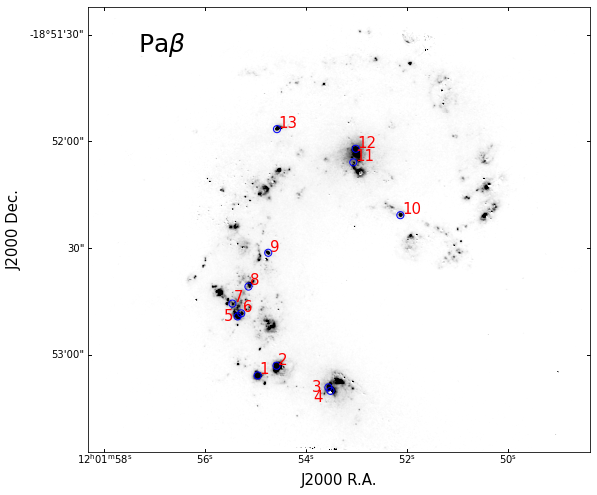

In [105]:
%%capture --no-display
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111, projection=wcs_north)
# ax.imshow(data_north, origin='lower',vmax=1,cmap='Greys')
# ax.imshow(data_north, origin='lower', vmax=46, cmap='Greys') # I band
ax.imshow(data_north, origin='lower', vmax=0.6, vmin=0, cmap='Greys')

## overlay the radio sources
ras = [coord.ra for coord in coords]
decs = [coord.dec for coord in coords]
positions = SkyCoord(ra = ras, dec = decs)
aper = SkyCircularAperture(positions, 1*u.arcsec)
aper_pix = aper.to_pixel(wcs_north)
aper_pix.plot(color='blue')

## overlay the label
txts = ['1','2','3','4','5','6','7','8','9','10','11','12','13']
coords_pix = []
for coord in coords_txt:
    coord_pix = coord.to_pixel(wcs_north)
    coords_pix.append(coord_pix)
for i, txt in enumerate(txts):
    plt.text(coords_pix[i][0], coords_pix[i][1], txt, fontsize=15,color='red')

## set the label and ticks
ax.tick_params(direction="in")
ax.set_xlabel('J2000 R.A.', fontsize=15)
ax.set_ylabel('J2000 Dec.', fontsize=15)
# plt.annotate(r'Pa$\beta$', xy=(0.1,0.95), xytext=(0.1,0.9), 
#              xycoords='axes fraction', fontsize=25)
plt.annotate(r'Pa$\beta$', xy=(0.1,0.95), xytext=(0.1,0.9), 
             xycoords='axes fraction', fontsize=25)

# save figure
plt.savefig(picDir+'HST_'+str(datatype)+'_overlay_cluster.pdf',bbox_inches='tight')

Plot individual regions and overlay radio contours

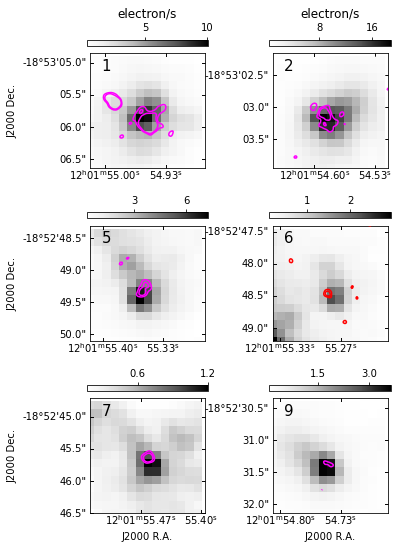

In [104]:
%%capture --no-display
region_labels = [1,2,5,6,7,9]
indices = [0,1,4,5,6,8]
cut_size = u.Quantity((0.03,0.03), u.arcmin)
coords_zoom = [coords[i] for i in indices]
distances = []

fig = plt.figure(figsize=(6,9))
for i, coord in enumerate(coords_zoom):
    # show the optical image
    region_wcs, region_data = cut_2d(data_north, coord, cut_size, wcs_north)
    ax = fig.add_subplot(3,2,i+1, projection=region_wcs)
    im = ax.imshow(region_data, origin='lower',cmap='Greys')
    cbar = plt.colorbar(im, location='top',shrink=0.8)
    
    # set the xlimit and ylimit
    ax.set_xlim(0, np.shape(region_data)[0])
    ax.set_ylim(0, np.shape(region_data)[1])
    
    # set the title for x and y axis
    ax.set_ylabel(' ')
    
    # show the radio contour
    fitsfile = imageDir + str(region_labels[i]) +'_band3_SC_p5_GMCcut.fits'
    levels = 1.1e-5 * np.array([5,8])
    colors = 'magenta'
    if i ==3: # for source 6
        fitsfile = imageDir + str(region_labels[i]) +'_band7_SC_p5_GMCcut.fits'
        levels = 4.1e-5 * np.array([3,4])
        colors = 'red'
    radio_wcs, radioData_cut = fits_import(fitsfile)
#     radio_contour, footprint = reproject_exact((radioData_cut, radio_wcs), region_wcs, shape_out=np.shape(region_data))
    ax.contour(radioData_cut, origin='lower', transform=ax.get_transform(radio_wcs),
               levels=levels,colors=colors,linewidths=1.5)

    # add label to individual pictures
    plt.annotate(str(region_labels[i]),xy=(0.1,0.85), xycoords='axes fraction', fontsize=15)
    
    # add label for x and y axis
    if i%2 == 0:
        ax.set_ylabel('J2000 Dec.')
    else:
        ax.set_ylabel(' ')
    if i/2 >= 2:
        ax.set_xlabel('J2000 R.A.')
    else:
        ax.set_xlabel(' ')
        
    # reduce the tick number in the x-axis
    lon = ax.coords[0]; lat = ax.coords[1]
    ax.tick_params(direction='in')
    lon.set_ticks(spacing=1*u.arcsec)
    
    # add colorbar unit as suptitle for each column
    if i in [0,1]:
        cbar.ax.set_title('electron/s')
    cbar.ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    
plt.savefig(picDir+'HST_'+str(datatype)+'_individual.pdf',bbox_inches='tight')

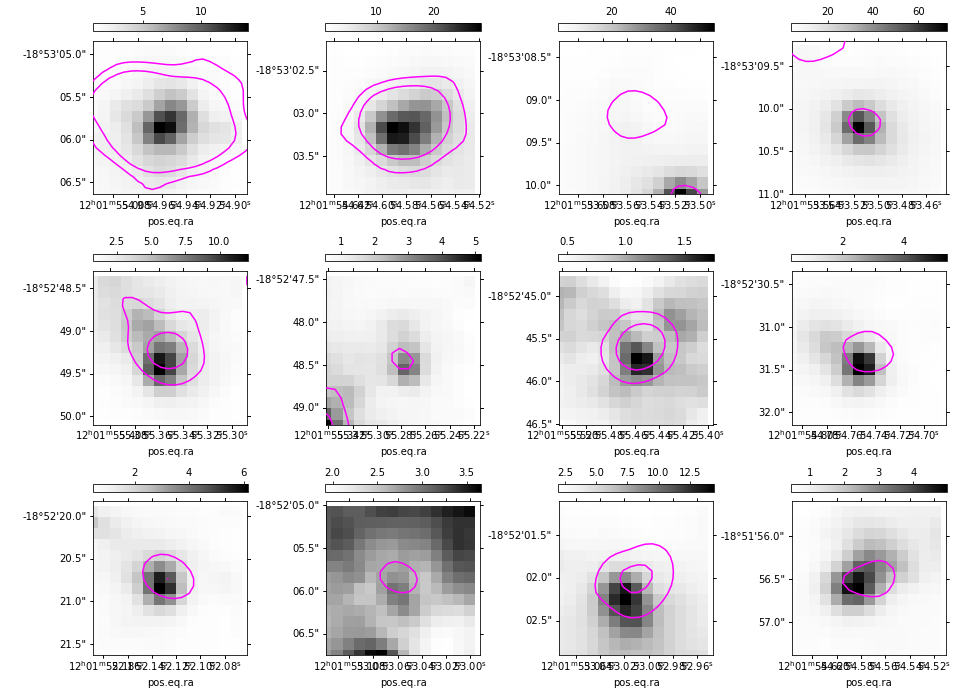

In [64]:
%%capture --no-display
region_labels = [1,2,3,4,5,6,7,9,10,11,12,13]
indices = [0,1,2,3,4,5,6,8,9,10,11,12]
cut_size = u.Quantity((0.03,0.03), u.arcmin)
coords_zoom = [coords[i] for i in indices]
distances = []

fig = plt.figure(figsize=(16,12))
for i, coord in enumerate(coords_zoom):
    # show the optical image
    region_wcs, region_data = cut_2d(data_north, coord, cut_size, wcs_north)
    ax = fig.add_subplot(3,4,i+1, projection=region_wcs)
    im = ax.imshow(region_data, origin='lower',cmap='Greys')
    cbar = plt.colorbar(im, location='top',shrink=0.8)
    
    # set the xlimit and ylimit
    ax.set_xlim(0, np.shape(region_data)[0])
    ax.set_ylim(0, np.shape(region_data)[1])
    
    # set the title for x and y axis
    ax.set_ylabel(' ')
    
    # show the radio contour
    fitsfile = imageDir + str(region_labels[i]) +'_band3_GMC.fits'
    levels = 1.1e-5 * np.array([7,15])
    colors = 'magenta'
    radio_wcs, radioData_cut = fits_import(fitsfile)
#     radio_contour, footprint = reproject_exact((radioData_cut, radio_wcs), region_wcs, shape_out=np.shape(region_data))
    ax.contour(radioData_cut, origin='lower', transform=ax.get_transform(radio_wcs),
               levels=levels,colors=colors,linewidths=1.5)
    
    # measure the distance
plt.savefig(picDir+'HST_'+str(datatype)+'_individual_GMC.pdf')

#### Show the I band image

In [67]:
datatype = 'I'
fitsimage = imageDir + 'Antennae_HST_'+str(datatype)+'_north.fits'
wcs_north, data_north = fits_import(fitsimage)

In [68]:
center = SkyCoord(ra=180.47230711292*u.deg, dec=-18.873546574305 *u.deg)
cut_size = u.Quantity((125,141), u.arcsec)
wcs_north_cut, data_north_cut = cut_2d(data_north, center, cut_size, wcs_north) 

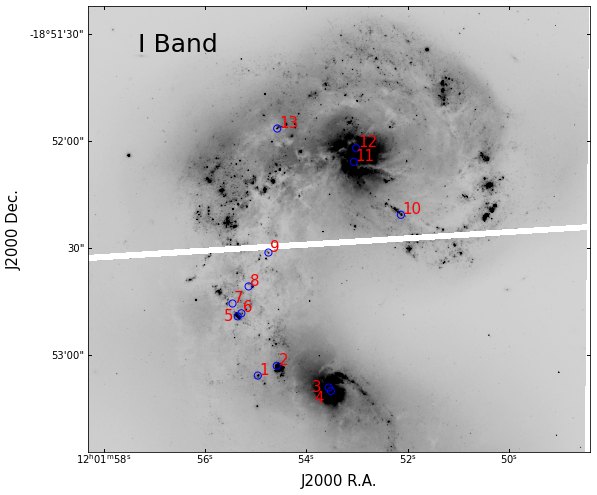

In [69]:
%%capture --no-display
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111, projection=wcs_north_cut)
ax.imshow(data_north_cut, origin='lower',vmax=0.5,cmap='Greys')

## overlay the radio sources
ras = [coord.ra for coord in coords]
decs = [coord.dec for coord in coords]
positions = SkyCoord(ra = ras, dec = decs)
aper = SkyCircularAperture(positions, 1*u.arcsec)
aper_pix = aper.to_pixel(wcs_north_cut)
aper_pix.plot(color='blue')

## overlay the label
txts = ['1','2','3','4','5','6','7','8','9','10','11','12','13']
coords_pix = []
for coord in coords_txt:
    coord_pix = coord.to_pixel(wcs_north_cut)
    coords_pix.append(coord_pix)
for i, txt in enumerate(txts):
    plt.text(coords_pix[i][0], coords_pix[i][1], txt, fontsize=15,color='red')

## set the label and ticks
ax.tick_params(direction="in")
ax.set_xlabel('J2000 R.A.', fontsize=15)
ax.set_ylabel('J2000 Dec.', fontsize=15)
plt.annotate(r'I Band', xy=(0.1,0.95), xytext=(0.1,0.9), 
             xycoords='axes fraction', fontsize=25)

# save figure
plt.savefig(picDir+'HST_'+str(datatype)+'_overlay_cluster.pdf',bbox_inches='tight')

Plot individual regions and overlay radio contours

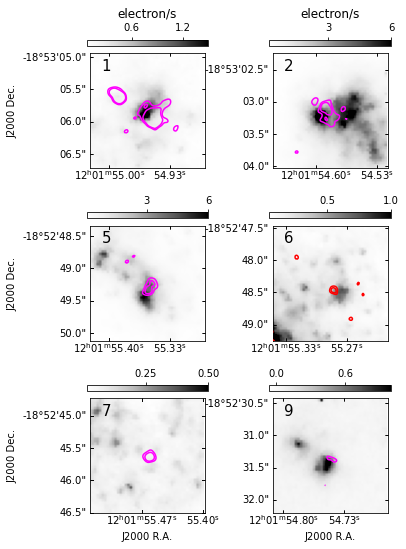

In [70]:
%%capture --no-display
region_labels = [1,2,5,6,7,9]
indices = [0,1,4,5,6,8]
cut_size = u.Quantity((0.03,0.03), u.arcmin)
coords_zoom = [coords[i] for i in indices]
distances = []
vmaxes = [1.5, 6, 6, 1, 0.5, 1]

fig = plt.figure(figsize=(6,9))
for i, coord in enumerate(coords_zoom):
    # show the optical image
    region_wcs, region_data = cut_2d(data_north, coord, cut_size, wcs_north)
    ax = fig.add_subplot(3,2,i+1, projection=region_wcs)
    im = ax.imshow(region_data, origin='lower',cmap='Greys', vmax=vmaxes[i])
    cbar = plt.colorbar(im, location='top',shrink=0.8)
    
    # set the xlimit and ylimit
    ax.set_xlim(0, np.shape(region_data)[0])
    ax.set_ylim(0, np.shape(region_data)[1])
    
    # set the title for x and y axis
    ax.set_ylabel(' ')
    
    # show the radio contour
    fitsfile = imageDir + str(region_labels[i]) +'_band3_SC_p5_GMCcut.fits'
    levels = 1.1e-5 * np.array([5,8])
    colors = 'magenta'
    if i ==3: # for source 6
        fitsfile = imageDir + str(region_labels[i]) +'_band7_SC_p5_GMCcut.fits'
        levels = 4.1e-5 * np.array([3,4])
        colors = 'red'
    radio_wcs, radioData_cut = fits_import(fitsfile)
#     radio_contour, footprint = reproject_exact((radioData_cut, radio_wcs), region_wcs, shape_out=np.shape(region_data))
    ax.contour(radioData_cut, origin='lower', transform=ax.get_transform(radio_wcs),
               levels=levels,colors=colors,linewidths=1.5)

    # add label to individual pictures
    plt.annotate(str(region_labels[i]),xy=(0.1,0.85), xycoords='axes fraction', fontsize=15)
    
    # add label for x and y axis
    if i%2 == 0:
        ax.set_ylabel('J2000 Dec.')
    else:
        ax.set_ylabel(' ')
    if i/2 >= 2:
        ax.set_xlabel('J2000 R.A.')
    else:
        ax.set_xlabel(' ')
        
    # reduce the tick number in the x-axis
    lon = ax.coords[0]; lat = ax.coords[1]
    ax.tick_params(direction='in')
    lon.set_ticks(spacing=1*u.arcsec)
    
    # add colorbar unit as suptitle for each column
    if i in [0,1]:
        cbar.ax.set_title('electron/s')
    cbar.ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    
plt.savefig(picDir+'HST_'+str(datatype)+'_individual.pdf',bbox_inches='tight')